In [3]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [5]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.3.1


In [7]:
!pip install matplotlib

  Using cached matplotlib-3.2.2-cp37-cp37m-win_amd64.whl (9.2 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.2.0-cp37-none-win_amd64.whl (57 kB)


In [11]:
#-*- coding: utf-8 -*-

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [ ]:
#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("../gan_images"):
    os.makedirs("../gan_images")

np.random.seed(3)
tf.random.set_seed(3)   

In [12]:
#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [13]:
#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [14]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

discriminator.trainable = False

In [15]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [19]:
#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):
    # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("../gan_images/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.3907  g_loss:0.9483
epoch:1  d_loss:0.4478  g_loss:0.8956
epoch:2  d_loss:0.4043  g_loss:0.9505
epoch:3  d_loss:0.3737  g_loss:1.0008
epoch:4  d_loss:0.3795  g_loss:1.0678
epoch:5  d_loss:0.3609  g_loss:1.0039
epoch:6  d_loss:0.3279  g_loss:1.0446
epoch:7  d_loss:0.2733  g_loss:1.1678
epoch:8  d_loss:0.2461  g_loss:1.4939
epoch:9  d_loss:0.2691  g_loss:1.5173
epoch:10  d_loss:0.3533  g_loss:1.5887
epoch:11  d_loss:0.2456  g_loss:1.7462
epoch:12  d_loss:0.2732  g_loss:1.7873
epoch:13  d_loss:0.1894  g_loss:2.1557
epoch:14  d_loss:0.1887  g_loss:2.8859
epoch:15  d_loss:0.2565  g_loss:2.9591
epoch:16  d_loss:0.1057  g_loss:3.4155
epoch:17  d_loss:0.2318  g_loss:2.6839
epoch:18  d_loss:0.2934  g_loss:2.5960
epoch:19  d_loss:0.2995  g_loss:2.7973
epoch:20  d_loss:0.2637  g_loss:2.7653
epoch:21  d_loss:0.4138  g_loss:1.7967
epoch:22  d_loss:0.3093  g_loss:2.0529
epoch:23  d_loss:0.2534  g_loss:2.4059
epoch:24  d_loss:0.2137  g_loss:2.4880
epoch:25  d_loss:0.1517  g_loss:2.2

epoch:208  d_loss:0.5974  g_loss:1.7761
epoch:209  d_loss:0.7205  g_loss:1.7495
epoch:210  d_loss:0.6512  g_loss:1.7035
epoch:211  d_loss:0.7020  g_loss:1.4222
epoch:212  d_loss:0.6086  g_loss:1.4531
epoch:213  d_loss:0.5137  g_loss:1.7637
epoch:214  d_loss:0.4982  g_loss:1.8419
epoch:215  d_loss:0.4015  g_loss:2.0750
epoch:216  d_loss:0.5754  g_loss:2.0287
epoch:217  d_loss:0.3817  g_loss:1.8205
epoch:218  d_loss:0.5449  g_loss:1.8955
epoch:219  d_loss:0.4317  g_loss:1.9924
epoch:220  d_loss:0.5726  g_loss:1.7908
epoch:221  d_loss:0.3230  g_loss:2.4736
epoch:222  d_loss:0.5272  g_loss:1.9347
epoch:223  d_loss:0.3545  g_loss:2.1690
epoch:224  d_loss:0.7057  g_loss:1.8973
epoch:225  d_loss:0.5118  g_loss:1.8425
epoch:226  d_loss:0.4527  g_loss:1.7162
epoch:227  d_loss:0.3883  g_loss:2.0788
epoch:228  d_loss:0.4320  g_loss:2.1558
epoch:229  d_loss:0.4356  g_loss:2.1425
epoch:230  d_loss:0.6279  g_loss:1.7948
epoch:231  d_loss:0.4540  g_loss:2.0229
epoch:232  d_loss:0.4298  g_loss:2.0164


epoch:413  d_loss:0.3298  g_loss:2.0579
epoch:414  d_loss:0.4314  g_loss:1.9941
epoch:415  d_loss:0.5118  g_loss:2.0412
epoch:416  d_loss:0.2527  g_loss:2.6877
epoch:417  d_loss:0.3203  g_loss:2.7461
epoch:418  d_loss:0.3654  g_loss:2.4988
epoch:419  d_loss:0.3374  g_loss:1.8755
epoch:420  d_loss:0.3904  g_loss:1.6165
epoch:421  d_loss:0.3717  g_loss:1.9740
epoch:422  d_loss:0.3570  g_loss:2.2807
epoch:423  d_loss:0.4237  g_loss:2.1609
epoch:424  d_loss:0.3851  g_loss:1.9740
epoch:425  d_loss:0.3710  g_loss:1.6666
epoch:426  d_loss:0.3449  g_loss:1.9400
epoch:427  d_loss:0.2380  g_loss:2.2277
epoch:428  d_loss:0.3661  g_loss:2.1758
epoch:429  d_loss:0.3171  g_loss:2.2700
epoch:430  d_loss:0.3414  g_loss:1.9504
epoch:431  d_loss:0.3177  g_loss:1.9835
epoch:432  d_loss:0.2497  g_loss:2.5726
epoch:433  d_loss:0.3303  g_loss:2.5592
epoch:434  d_loss:0.2649  g_loss:2.3241
epoch:435  d_loss:0.2786  g_loss:2.7237
epoch:436  d_loss:0.3721  g_loss:3.0378
epoch:437  d_loss:0.2432  g_loss:2.8784


epoch:618  d_loss:0.6989  g_loss:1.6711
epoch:619  d_loss:0.6622  g_loss:1.3507
epoch:620  d_loss:0.5315  g_loss:1.7167
epoch:621  d_loss:0.4834  g_loss:1.4216
epoch:622  d_loss:0.5515  g_loss:1.1780
epoch:623  d_loss:0.6203  g_loss:1.3085
epoch:624  d_loss:0.4324  g_loss:1.8619
epoch:625  d_loss:0.4636  g_loss:1.3718
epoch:626  d_loss:0.4291  g_loss:1.6691
epoch:627  d_loss:0.3144  g_loss:2.0288
epoch:628  d_loss:0.3622  g_loss:1.7421
epoch:629  d_loss:0.3549  g_loss:2.1839
epoch:630  d_loss:0.2312  g_loss:2.5148
epoch:631  d_loss:0.2450  g_loss:2.6030
epoch:632  d_loss:0.2224  g_loss:1.8628
epoch:633  d_loss:0.2312  g_loss:1.9481
epoch:634  d_loss:0.1549  g_loss:2.0783
epoch:635  d_loss:0.2846  g_loss:2.2534
epoch:636  d_loss:0.2800  g_loss:1.9525
epoch:637  d_loss:0.3944  g_loss:2.0288
epoch:638  d_loss:0.2408  g_loss:2.3669
epoch:639  d_loss:0.3030  g_loss:2.0029
epoch:640  d_loss:0.2763  g_loss:2.1998
epoch:641  d_loss:0.3388  g_loss:2.0699
epoch:642  d_loss:0.3242  g_loss:1.6227


epoch:823  d_loss:0.2820  g_loss:2.5070
epoch:824  d_loss:0.3351  g_loss:2.2956
epoch:825  d_loss:0.3785  g_loss:1.9405
epoch:826  d_loss:0.2741  g_loss:2.3278
epoch:827  d_loss:0.3478  g_loss:2.2756
epoch:828  d_loss:0.2844  g_loss:2.3921
epoch:829  d_loss:0.2400  g_loss:2.9076
epoch:830  d_loss:0.3547  g_loss:3.2046
epoch:831  d_loss:0.3779  g_loss:2.4243
epoch:832  d_loss:0.4654  g_loss:2.1765
epoch:833  d_loss:0.4929  g_loss:1.8526
epoch:834  d_loss:0.4668  g_loss:2.0908
epoch:835  d_loss:0.4923  g_loss:2.4589
epoch:836  d_loss:0.4776  g_loss:2.7063
epoch:837  d_loss:0.4241  g_loss:2.7047
epoch:838  d_loss:0.3927  g_loss:2.3479
epoch:839  d_loss:0.4338  g_loss:1.6432
epoch:840  d_loss:0.5703  g_loss:1.5659
epoch:841  d_loss:0.4201  g_loss:2.2157
epoch:842  d_loss:0.6519  g_loss:2.0390
epoch:843  d_loss:0.4672  g_loss:1.5242
epoch:844  d_loss:0.3421  g_loss:2.2356
epoch:845  d_loss:0.3697  g_loss:2.2404
epoch:846  d_loss:0.4195  g_loss:2.2125
epoch:847  d_loss:0.4988  g_loss:2.0764


epoch:1028  d_loss:0.3924  g_loss:1.8599
epoch:1029  d_loss:0.3468  g_loss:2.3962
epoch:1030  d_loss:0.2853  g_loss:2.4222
epoch:1031  d_loss:0.3261  g_loss:2.9679
epoch:1032  d_loss:0.5203  g_loss:2.5904
epoch:1033  d_loss:0.4680  g_loss:2.0190
epoch:1034  d_loss:0.4630  g_loss:1.4684
epoch:1035  d_loss:0.5169  g_loss:1.5068
epoch:1036  d_loss:0.3751  g_loss:1.9632
epoch:1037  d_loss:0.3688  g_loss:2.0246
epoch:1038  d_loss:0.4409  g_loss:1.6798
epoch:1039  d_loss:0.4761  g_loss:1.6910
epoch:1040  d_loss:0.4161  g_loss:1.9642
epoch:1041  d_loss:0.4796  g_loss:2.0489
epoch:1042  d_loss:0.5363  g_loss:1.9577
epoch:1043  d_loss:0.4330  g_loss:2.1946
epoch:1044  d_loss:0.5927  g_loss:1.6915
epoch:1045  d_loss:0.4070  g_loss:1.7221
epoch:1046  d_loss:0.4432  g_loss:1.5908
epoch:1047  d_loss:0.5827  g_loss:1.7015
epoch:1048  d_loss:0.4401  g_loss:1.7030
epoch:1049  d_loss:0.4686  g_loss:2.0914
epoch:1050  d_loss:0.5632  g_loss:1.9848
epoch:1051  d_loss:0.4422  g_loss:1.6628
epoch:1052  d_lo

epoch:1228  d_loss:0.4534  g_loss:1.8623
epoch:1229  d_loss:0.4961  g_loss:1.6837
epoch:1230  d_loss:0.4869  g_loss:1.6793
epoch:1231  d_loss:0.4399  g_loss:1.3686
epoch:1232  d_loss:0.4274  g_loss:1.6977
epoch:1233  d_loss:0.5226  g_loss:1.6749
epoch:1234  d_loss:0.5154  g_loss:1.6772
epoch:1235  d_loss:0.5188  g_loss:1.8379
epoch:1236  d_loss:0.3932  g_loss:1.6658
epoch:1237  d_loss:0.4720  g_loss:1.6586
epoch:1238  d_loss:0.5484  g_loss:1.6078
epoch:1239  d_loss:0.5331  g_loss:2.0727
epoch:1240  d_loss:0.5946  g_loss:1.9945
epoch:1241  d_loss:0.6172  g_loss:1.6983
epoch:1242  d_loss:0.4643  g_loss:1.5358
epoch:1243  d_loss:0.4769  g_loss:1.2144
epoch:1244  d_loss:0.5946  g_loss:1.1969
epoch:1245  d_loss:0.5230  g_loss:1.6856
epoch:1246  d_loss:0.3562  g_loss:1.8023
epoch:1247  d_loss:0.4306  g_loss:2.1644
epoch:1248  d_loss:0.4567  g_loss:1.6885
epoch:1249  d_loss:0.5418  g_loss:1.7032
epoch:1250  d_loss:0.6385  g_loss:1.5307
epoch:1251  d_loss:0.4500  g_loss:1.9112
epoch:1252  d_lo

epoch:1428  d_loss:0.6909  g_loss:1.3833
epoch:1429  d_loss:0.5458  g_loss:1.3272
epoch:1430  d_loss:0.5005  g_loss:1.7091
epoch:1431  d_loss:0.6561  g_loss:1.5968
epoch:1432  d_loss:0.4879  g_loss:1.4446
epoch:1433  d_loss:0.6280  g_loss:1.5225
epoch:1434  d_loss:0.4490  g_loss:1.7748
epoch:1435  d_loss:0.5961  g_loss:1.2096
epoch:1436  d_loss:0.4767  g_loss:1.4831
epoch:1437  d_loss:0.6858  g_loss:1.4166
epoch:1438  d_loss:0.5407  g_loss:1.3204
epoch:1439  d_loss:0.5745  g_loss:1.7507
epoch:1440  d_loss:0.5108  g_loss:1.9092
epoch:1441  d_loss:0.6443  g_loss:1.5677
epoch:1442  d_loss:0.5856  g_loss:1.6392
epoch:1443  d_loss:0.5501  g_loss:1.4505
epoch:1444  d_loss:0.5010  g_loss:1.4038
epoch:1445  d_loss:0.4909  g_loss:1.4876
epoch:1446  d_loss:0.4917  g_loss:1.3126
epoch:1447  d_loss:0.6218  g_loss:1.5081
epoch:1448  d_loss:0.4823  g_loss:1.4330
epoch:1449  d_loss:0.3864  g_loss:1.7161
epoch:1450  d_loss:0.4104  g_loss:1.3798
epoch:1451  d_loss:0.3998  g_loss:1.6052
epoch:1452  d_lo

epoch:1628  d_loss:0.4888  g_loss:1.8421
epoch:1629  d_loss:0.5165  g_loss:1.7511
epoch:1630  d_loss:0.5400  g_loss:1.6100
epoch:1631  d_loss:0.5836  g_loss:1.5463
epoch:1632  d_loss:0.5092  g_loss:1.3888
epoch:1633  d_loss:0.6603  g_loss:1.3136
epoch:1634  d_loss:0.5354  g_loss:1.3054
epoch:1635  d_loss:0.3460  g_loss:1.6580
epoch:1636  d_loss:0.5085  g_loss:1.5133
epoch:1637  d_loss:0.5646  g_loss:1.2308
epoch:1638  d_loss:0.5066  g_loss:1.3004
epoch:1639  d_loss:0.4733  g_loss:1.6235
epoch:1640  d_loss:0.5343  g_loss:1.5260
epoch:1641  d_loss:0.4402  g_loss:1.5599
epoch:1642  d_loss:0.4565  g_loss:1.7132
epoch:1643  d_loss:0.4750  g_loss:1.7814
epoch:1644  d_loss:0.4999  g_loss:2.1336
epoch:1645  d_loss:0.4982  g_loss:1.8242
epoch:1646  d_loss:0.4662  g_loss:1.5316
epoch:1647  d_loss:0.4036  g_loss:1.8643
epoch:1648  d_loss:0.4946  g_loss:1.5806
epoch:1649  d_loss:0.4947  g_loss:1.5935
epoch:1650  d_loss:0.4479  g_loss:1.4793
epoch:1651  d_loss:0.4049  g_loss:1.9338
epoch:1652  d_lo

epoch:1828  d_loss:0.5148  g_loss:1.5441
epoch:1829  d_loss:0.5123  g_loss:1.3341
epoch:1830  d_loss:0.4352  g_loss:1.4731
epoch:1831  d_loss:0.5541  g_loss:1.4702
epoch:1832  d_loss:0.4404  g_loss:1.5257
epoch:1833  d_loss:0.3670  g_loss:1.6584
epoch:1834  d_loss:0.3947  g_loss:1.7169
epoch:1835  d_loss:0.4830  g_loss:1.4359
epoch:1836  d_loss:0.4481  g_loss:1.6553
epoch:1837  d_loss:0.5148  g_loss:1.4197
epoch:1838  d_loss:0.4593  g_loss:1.5645
epoch:1839  d_loss:0.4178  g_loss:1.8854
epoch:1840  d_loss:0.4157  g_loss:2.0171
epoch:1841  d_loss:0.5284  g_loss:1.9593
epoch:1842  d_loss:0.4892  g_loss:1.8021
epoch:1843  d_loss:0.5375  g_loss:1.3747
epoch:1844  d_loss:0.5396  g_loss:1.2495
epoch:1845  d_loss:0.4907  g_loss:1.3293
epoch:1846  d_loss:0.4027  g_loss:1.5702
epoch:1847  d_loss:0.4791  g_loss:1.9904
epoch:1848  d_loss:0.5651  g_loss:1.7469
epoch:1849  d_loss:0.4947  g_loss:1.7246
epoch:1850  d_loss:0.7051  g_loss:1.4517
epoch:1851  d_loss:0.5522  g_loss:1.1991
epoch:1852  d_lo

epoch:2028  d_loss:0.4406  g_loss:1.5922
epoch:2029  d_loss:0.4070  g_loss:1.9879
epoch:2030  d_loss:0.5166  g_loss:1.6771
epoch:2031  d_loss:0.4301  g_loss:1.8360
epoch:2032  d_loss:0.5335  g_loss:1.4797
epoch:2033  d_loss:0.4784  g_loss:1.3374
epoch:2034  d_loss:0.4779  g_loss:1.4068
epoch:2035  d_loss:0.5809  g_loss:1.2871
epoch:2036  d_loss:0.4299  g_loss:1.5542
epoch:2037  d_loss:0.5027  g_loss:1.8401
epoch:2038  d_loss:0.4605  g_loss:1.9489
epoch:2039  d_loss:0.3850  g_loss:1.9475
epoch:2040  d_loss:0.4831  g_loss:2.2262
epoch:2041  d_loss:0.5808  g_loss:1.6126
epoch:2042  d_loss:0.4820  g_loss:1.4138
epoch:2043  d_loss:0.3716  g_loss:1.7367
epoch:2044  d_loss:0.5691  g_loss:1.2843
epoch:2045  d_loss:0.5184  g_loss:1.4705
epoch:2046  d_loss:0.3616  g_loss:1.7766
epoch:2047  d_loss:0.6459  g_loss:1.8338
epoch:2048  d_loss:0.7297  g_loss:1.8844
epoch:2049  d_loss:0.5321  g_loss:1.3647
epoch:2050  d_loss:0.6160  g_loss:1.4831
epoch:2051  d_loss:0.5139  g_loss:1.2839
epoch:2052  d_lo

epoch:2228  d_loss:0.4637  g_loss:1.8702
epoch:2229  d_loss:0.5316  g_loss:1.4938
epoch:2230  d_loss:0.5207  g_loss:1.5741
epoch:2231  d_loss:0.4679  g_loss:1.3967
epoch:2232  d_loss:0.5285  g_loss:1.4640
epoch:2233  d_loss:0.4934  g_loss:1.9264
epoch:2234  d_loss:0.4238  g_loss:2.1580
epoch:2235  d_loss:0.5371  g_loss:2.1358
epoch:2236  d_loss:0.4556  g_loss:2.3470
epoch:2237  d_loss:0.5410  g_loss:2.0351
epoch:2238  d_loss:0.5546  g_loss:1.5144
epoch:2239  d_loss:0.5375  g_loss:1.2159
epoch:2240  d_loss:0.4264  g_loss:1.5639
epoch:2241  d_loss:0.5025  g_loss:1.7316
epoch:2242  d_loss:0.5434  g_loss:1.8927
epoch:2243  d_loss:0.5604  g_loss:1.3424
epoch:2244  d_loss:0.5289  g_loss:1.5341
epoch:2245  d_loss:0.4299  g_loss:1.4591
epoch:2246  d_loss:0.5124  g_loss:1.4072
epoch:2247  d_loss:0.5274  g_loss:1.4168
epoch:2248  d_loss:0.3932  g_loss:1.7031
epoch:2249  d_loss:0.4892  g_loss:1.7391
epoch:2250  d_loss:0.6008  g_loss:1.5841
epoch:2251  d_loss:0.5019  g_loss:1.7732
epoch:2252  d_lo

epoch:2428  d_loss:0.4647  g_loss:1.5883
epoch:2429  d_loss:0.5087  g_loss:1.4767
epoch:2430  d_loss:0.6342  g_loss:1.3126
epoch:2431  d_loss:0.4585  g_loss:1.5422
epoch:2432  d_loss:0.5239  g_loss:2.0015
epoch:2433  d_loss:0.7014  g_loss:1.2914
epoch:2434  d_loss:0.6769  g_loss:1.6340
epoch:2435  d_loss:0.5746  g_loss:1.5754
epoch:2436  d_loss:0.6536  g_loss:1.4379
epoch:2437  d_loss:0.6658  g_loss:1.3734
epoch:2438  d_loss:0.6069  g_loss:1.6373
epoch:2439  d_loss:0.5360  g_loss:1.5884
epoch:2440  d_loss:0.4779  g_loss:1.6964
epoch:2441  d_loss:0.5040  g_loss:1.3926
epoch:2442  d_loss:0.5745  g_loss:1.3528
epoch:2443  d_loss:0.3333  g_loss:1.5081
epoch:2444  d_loss:0.4753  g_loss:1.8595
epoch:2445  d_loss:0.5579  g_loss:1.4786
epoch:2446  d_loss:0.5128  g_loss:1.6933
epoch:2447  d_loss:0.5298  g_loss:1.4436
epoch:2448  d_loss:0.5047  g_loss:1.4128
epoch:2449  d_loss:0.5061  g_loss:1.3432
epoch:2450  d_loss:0.4708  g_loss:1.4668
epoch:2451  d_loss:0.5874  g_loss:1.1571
epoch:2452  d_lo

epoch:2628  d_loss:0.4962  g_loss:1.6637
epoch:2629  d_loss:0.4805  g_loss:1.8227
epoch:2630  d_loss:0.4306  g_loss:1.6106
epoch:2631  d_loss:0.4894  g_loss:1.5900
epoch:2632  d_loss:0.4428  g_loss:1.5635
epoch:2633  d_loss:0.7222  g_loss:1.5121
epoch:2634  d_loss:0.4682  g_loss:1.6310
epoch:2635  d_loss:0.4972  g_loss:1.4384
epoch:2636  d_loss:0.4533  g_loss:1.7068
epoch:2637  d_loss:0.4117  g_loss:1.7100
epoch:2638  d_loss:0.3811  g_loss:1.8105
epoch:2639  d_loss:0.6118  g_loss:1.4393
epoch:2640  d_loss:0.5054  g_loss:1.9586
epoch:2641  d_loss:0.4874  g_loss:1.5624
epoch:2642  d_loss:0.5278  g_loss:1.7941
epoch:2643  d_loss:0.4512  g_loss:1.9049
epoch:2644  d_loss:0.4510  g_loss:1.4471
epoch:2645  d_loss:0.4629  g_loss:1.1358
epoch:2646  d_loss:0.5893  g_loss:1.3206
epoch:2647  d_loss:0.3111  g_loss:1.6386
epoch:2648  d_loss:0.3678  g_loss:1.9596
epoch:2649  d_loss:0.6697  g_loss:1.7333
epoch:2650  d_loss:0.5896  g_loss:1.5743
epoch:2651  d_loss:0.4404  g_loss:1.8987
epoch:2652  d_lo

epoch:2828  d_loss:0.6790  g_loss:1.4680
epoch:2829  d_loss:0.6579  g_loss:1.2978
epoch:2830  d_loss:0.5700  g_loss:1.2481
epoch:2831  d_loss:0.6091  g_loss:1.4802
epoch:2832  d_loss:0.5598  g_loss:1.5821
epoch:2833  d_loss:0.4193  g_loss:1.6623
epoch:2834  d_loss:0.4597  g_loss:1.5435
epoch:2835  d_loss:0.4162  g_loss:1.7321
epoch:2836  d_loss:0.5543  g_loss:1.5088
epoch:2837  d_loss:0.5535  g_loss:1.7610
epoch:2838  d_loss:0.3567  g_loss:1.8647
epoch:2839  d_loss:0.4284  g_loss:1.6146
epoch:2840  d_loss:0.4787  g_loss:1.7325
epoch:2841  d_loss:0.3695  g_loss:1.9585
epoch:2842  d_loss:0.3102  g_loss:1.6742
epoch:2843  d_loss:0.5067  g_loss:1.6986
epoch:2844  d_loss:0.4124  g_loss:1.6846
epoch:2845  d_loss:0.4728  g_loss:1.6381
epoch:2846  d_loss:0.4104  g_loss:2.1386
epoch:2847  d_loss:0.3331  g_loss:2.2535
epoch:2848  d_loss:0.5437  g_loss:1.9256
epoch:2849  d_loss:0.3862  g_loss:2.2918
epoch:2850  d_loss:0.3854  g_loss:1.9923
epoch:2851  d_loss:0.3899  g_loss:2.2037
epoch:2852  d_lo

epoch:3028  d_loss:0.6146  g_loss:1.4512
epoch:3029  d_loss:0.4326  g_loss:1.4005
epoch:3030  d_loss:0.4052  g_loss:1.5750
epoch:3031  d_loss:0.6813  g_loss:1.3317
epoch:3032  d_loss:0.4900  g_loss:1.3814
epoch:3033  d_loss:0.5154  g_loss:1.4322
epoch:3034  d_loss:0.4413  g_loss:1.4231
epoch:3035  d_loss:0.4139  g_loss:1.4716
epoch:3036  d_loss:0.5684  g_loss:1.6243
epoch:3037  d_loss:0.5069  g_loss:1.4438
epoch:3038  d_loss:0.5083  g_loss:1.6461
epoch:3039  d_loss:0.3527  g_loss:1.4834
epoch:3040  d_loss:0.4215  g_loss:1.5185
epoch:3041  d_loss:0.2950  g_loss:1.6660
epoch:3042  d_loss:0.4475  g_loss:1.8973
epoch:3043  d_loss:0.4789  g_loss:1.6400
epoch:3044  d_loss:0.5284  g_loss:1.7538
epoch:3045  d_loss:0.5385  g_loss:1.3482
epoch:3046  d_loss:0.3143  g_loss:2.1122
epoch:3047  d_loss:0.5051  g_loss:1.7864
epoch:3048  d_loss:0.5231  g_loss:1.7384
epoch:3049  d_loss:0.5277  g_loss:1.7215
epoch:3050  d_loss:0.5159  g_loss:1.5831
epoch:3051  d_loss:0.5409  g_loss:1.5902
epoch:3052  d_lo

epoch:3228  d_loss:0.3910  g_loss:1.4252
epoch:3229  d_loss:0.5817  g_loss:1.7159
epoch:3230  d_loss:0.6186  g_loss:1.6089
epoch:3231  d_loss:0.6104  g_loss:1.3949
epoch:3232  d_loss:0.7132  g_loss:1.2887
epoch:3233  d_loss:0.4623  g_loss:1.5039
epoch:3234  d_loss:0.4197  g_loss:1.4114
epoch:3235  d_loss:0.5098  g_loss:1.4512
epoch:3236  d_loss:0.6255  g_loss:1.6039
epoch:3237  d_loss:0.4937  g_loss:1.3870
epoch:3238  d_loss:0.5369  g_loss:1.4438
epoch:3239  d_loss:0.4510  g_loss:1.3423
epoch:3240  d_loss:0.5656  g_loss:1.3913
epoch:3241  d_loss:0.5032  g_loss:1.5028
epoch:3242  d_loss:0.5336  g_loss:1.6928
epoch:3243  d_loss:0.5041  g_loss:1.5558
epoch:3244  d_loss:0.5072  g_loss:1.5947
epoch:3245  d_loss:0.5385  g_loss:1.4515
epoch:3246  d_loss:0.5838  g_loss:1.4582
epoch:3247  d_loss:0.5991  g_loss:1.1586
epoch:3248  d_loss:0.4746  g_loss:1.4049
epoch:3249  d_loss:0.5471  g_loss:1.4802
epoch:3250  d_loss:0.6135  g_loss:1.3572
epoch:3251  d_loss:0.4709  g_loss:1.5169
epoch:3252  d_lo

epoch:3428  d_loss:0.6172  g_loss:1.7837
epoch:3429  d_loss:0.4890  g_loss:1.6954
epoch:3430  d_loss:0.5608  g_loss:1.8361
epoch:3431  d_loss:0.4245  g_loss:1.4100
epoch:3432  d_loss:0.5391  g_loss:1.6280
epoch:3433  d_loss:0.4096  g_loss:1.4121
epoch:3434  d_loss:0.5847  g_loss:1.6392
epoch:3435  d_loss:0.5057  g_loss:1.2557
epoch:3436  d_loss:0.3719  g_loss:1.7275
epoch:3437  d_loss:0.5520  g_loss:1.3984
epoch:3438  d_loss:0.5099  g_loss:1.1920
epoch:3439  d_loss:0.4983  g_loss:1.5849
epoch:3440  d_loss:0.4004  g_loss:1.7728
epoch:3441  d_loss:0.5855  g_loss:1.7790
epoch:3442  d_loss:0.4956  g_loss:1.4583
epoch:3443  d_loss:0.5602  g_loss:1.3343
epoch:3444  d_loss:0.4316  g_loss:1.4987
epoch:3445  d_loss:0.4746  g_loss:1.4824
epoch:3446  d_loss:0.5407  g_loss:1.3647
epoch:3447  d_loss:0.4807  g_loss:1.6817
epoch:3448  d_loss:0.4990  g_loss:1.6448
epoch:3449  d_loss:0.4770  g_loss:1.7726
epoch:3450  d_loss:0.4751  g_loss:1.3707
epoch:3451  d_loss:0.4303  g_loss:1.5854
epoch:3452  d_lo

epoch:3628  d_loss:0.4993  g_loss:2.5050
epoch:3629  d_loss:0.3051  g_loss:2.2174
epoch:3630  d_loss:0.3043  g_loss:2.0803
epoch:3631  d_loss:0.3428  g_loss:1.9882
epoch:3632  d_loss:0.6694  g_loss:1.6709
epoch:3633  d_loss:0.4498  g_loss:1.9804
epoch:3634  d_loss:0.3193  g_loss:2.1690
epoch:3635  d_loss:0.5968  g_loss:1.6972
epoch:3636  d_loss:0.3139  g_loss:1.5935
epoch:3637  d_loss:0.5439  g_loss:1.8696
epoch:3638  d_loss:0.6809  g_loss:1.5794
epoch:3639  d_loss:0.5511  g_loss:1.8666
epoch:3640  d_loss:0.6480  g_loss:1.5994
epoch:3641  d_loss:0.5643  g_loss:1.5888
epoch:3642  d_loss:0.6087  g_loss:1.3982
epoch:3643  d_loss:0.4885  g_loss:1.2220
epoch:3644  d_loss:0.6225  g_loss:1.4394
epoch:3645  d_loss:0.5853  g_loss:1.3807
epoch:3646  d_loss:0.5221  g_loss:1.6645
epoch:3647  d_loss:0.4337  g_loss:1.8946
epoch:3648  d_loss:0.4469  g_loss:1.5626
epoch:3649  d_loss:0.4768  g_loss:1.8868
epoch:3650  d_loss:0.5374  g_loss:1.5935
epoch:3651  d_loss:0.7723  g_loss:1.5132
epoch:3652  d_lo

epoch:3828  d_loss:0.5007  g_loss:1.5628
epoch:3829  d_loss:0.4120  g_loss:1.5537
epoch:3830  d_loss:0.5090  g_loss:1.6726
epoch:3831  d_loss:0.5494  g_loss:1.5385
epoch:3832  d_loss:0.6047  g_loss:1.7951
epoch:3833  d_loss:0.6176  g_loss:1.9046
epoch:3834  d_loss:0.5249  g_loss:1.9651
epoch:3835  d_loss:0.4815  g_loss:1.6671
epoch:3836  d_loss:0.4588  g_loss:1.3586
epoch:3837  d_loss:0.4211  g_loss:1.6814
epoch:3838  d_loss:0.3962  g_loss:1.6678
epoch:3839  d_loss:0.5989  g_loss:1.8083
epoch:3840  d_loss:0.4635  g_loss:1.4560
epoch:3841  d_loss:0.6037  g_loss:1.4128
epoch:3842  d_loss:0.4242  g_loss:1.6959
epoch:3843  d_loss:0.3484  g_loss:1.9244
epoch:3844  d_loss:0.3815  g_loss:2.2283
epoch:3845  d_loss:0.4336  g_loss:1.7804
epoch:3846  d_loss:0.3847  g_loss:2.1295
epoch:3847  d_loss:0.3357  g_loss:1.4644
epoch:3848  d_loss:0.4021  g_loss:1.3155
epoch:3849  d_loss:0.6863  g_loss:1.7468
epoch:3850  d_loss:0.3714  g_loss:2.0795
epoch:3851  d_loss:0.4651  g_loss:1.6830
epoch:3852  d_lo

C:\Users\2\.conda\envs\gan_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


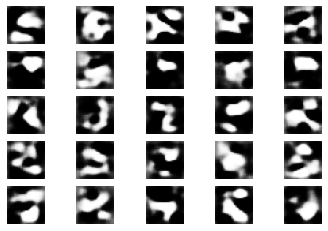

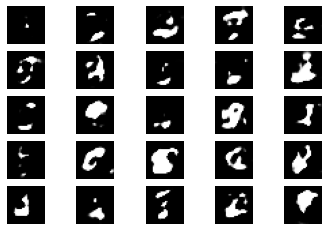

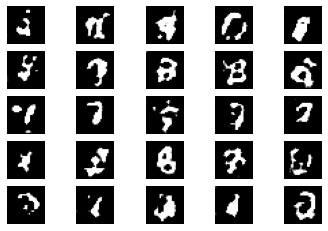

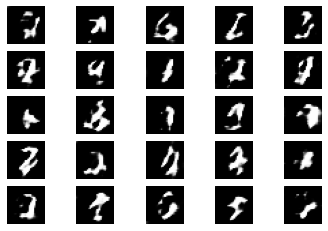

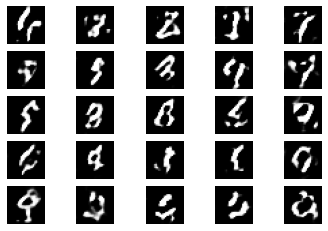

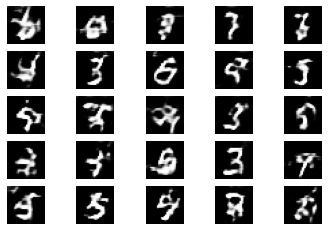

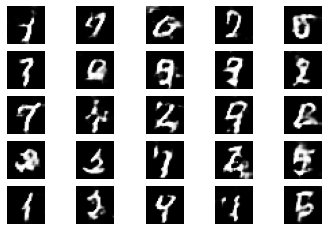

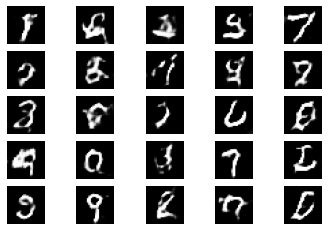

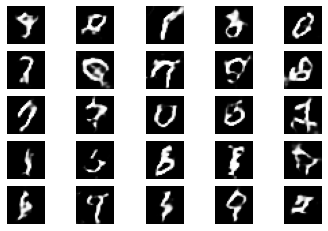

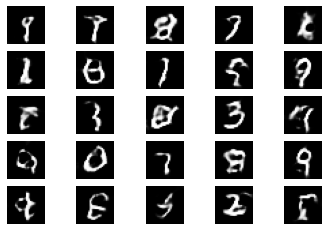

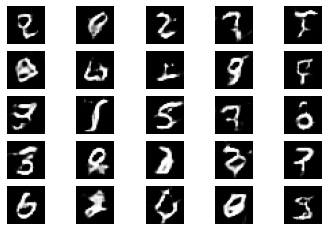

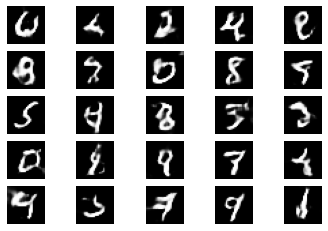

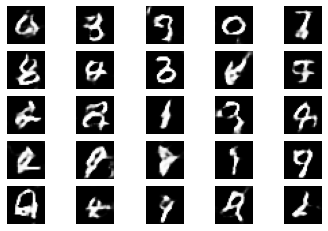

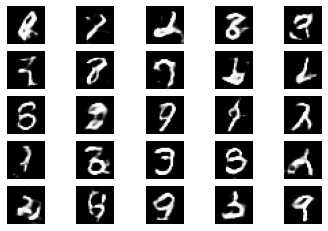

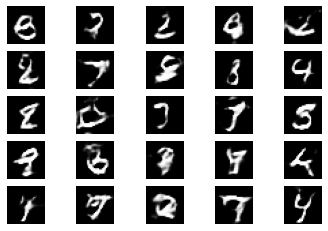

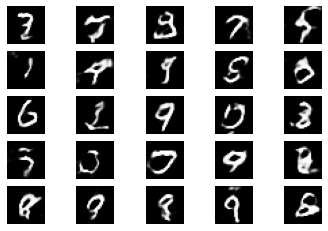

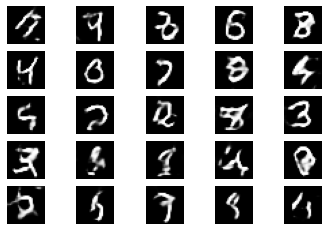

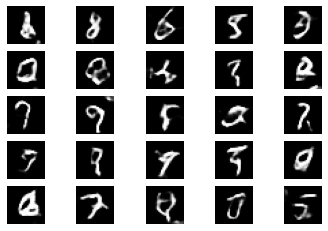

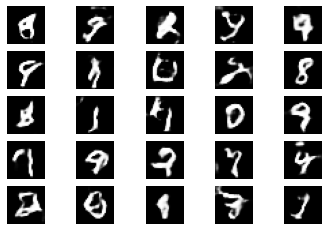

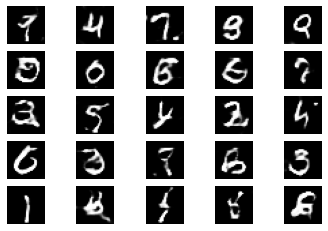

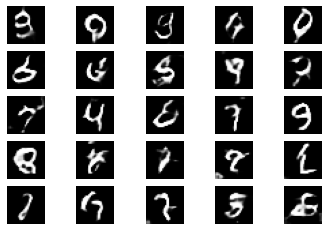

In [20]:
gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.